In [125]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [148]:
import warnings
warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
# import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
import np_utils

In [149]:
# set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version', keras.__version__)

# class labels
LABELS = [
    "30DBP","SACLR","APULL","MTE","45DBP","SAOCTE","IDBC","CGCR","DWC","SAODTE","DSP","SBLP","MIBP","DLR","CGOCTE"
]

TIME_PERIODS = 400  # the number of steps within one time segment

# The steps to take from one segment to the next; if this value is equal tobTIME_PERIODS, 
# then there is no overlap between the segments
STEP_DISTANCE = 200

keras version 3.6.0


In [150]:
def read_data(file_path):
    column_names = [
    "seconds_elapsed",
    "wristMotion_rotationRateX",
    "wristMotion_rotationRateY",
    "wristMotion_rotationRateZ",
    "wristMotion_gravityX",
    "wristMotion_gravityY",
    "wristMotion_gravityZ",
    "wristMotion_accelerationX",
    "wristMotion_accelerationY",
    "wristMotion_accelerationZ",
    "wristMotion_quaternionW",
    "wristMotion_quaternionX",
    "wristMotion_quaternionY",
    "wristMotion_quaternionZ",
    "Weight",
    "Set",
    "Reps",
    "Exercise Code",
    "Label Number",
    "FileNumber"
]
    df = pd.read_csv(file_path, header=None, names=column_names)
    df.dropna(axis=0, how='any', inplace=True)  # drop NaN values -> 필수!! without this, the accuracy never grow up
    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan
    
def show_basic_dataframe_info(dataframe):
    # shape: #_rows, #_columns
    print("Number of rows in the dataframe: %i" % (dataframe.shape[0]))
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))

In [151]:
df = read_data(r"D:\My projects\Health Tracker Band\IMUWorkoutClassification\AppleWatchRecordings\Whales1_ProcessedFilteredCombined\ProcessedFilteredCombined.csv")

In [152]:
df.isnull().sum()/ len(df)*100
df = df.drop_duplicates()

In [153]:
df.head(10)

,seconds_elapsed,wristMotion_rotationRateX,wristMotion_rotationRateY,wristMotion_rotationRateZ,wristMotion_gravityX,wristMotion_gravityY,wristMotion_gravityZ,wristMotion_accelerationX,wristMotion_accelerationY,wristMotion_accelerationZ,wristMotion_quaternionW,wristMotion_quaternionX,wristMotion_quaternionY,wristMotion_quaternionZ,Weight,Set,Reps,Exercise Code,Label Number,FileNumber
0,seconds_elapsed,wristMotion_rotationRateX,wristMotion_rotationRateY,wristMotion_rotationRateZ,wristMotion_gravityX,wristMotion_gravityY,wristMotion_gravityZ,wristMotion_accelerationX,wristMotion_accelerationY,wristMotion_accelerationZ,wristMotion_quaternionW,wristMotion_quaternionX,wristMotion_quaternionY,wristMotion_quaternionZ,Weight,Set,Reps,activity,ActivityEncoded,FileNumber
1,2.01,2.1551722482602127,-0.9342306251837303,-0.7548558662937046,-0.232678593431624,0.7684052819598386,-0.6273780314984694,0.3173635731833971,-0.041967702911285,0.1662758230317558,0.5278402498804063,-0.1346800183586077,-0.4212679405749242,0.7344684669174039,61.0,1.0,12.0,APULL,28.0,1
2,2.02,2.1273510472660555,-0.9032612724064282,-0.6839795138920943,-0.2344564331089851,0.7621436508749958,-0.6329425842004558,0.3165411611908095,-0.045781621835378,0.1643569972508783,0.525883368057875,-0.1305580203746354,-0.4185819182319052,0.7375068937934489,61.0,1.0,12.0,APULL,28.0,1
3,2.03,2.0995538831790537,-0.8723782594378214,-0.6134223690316829,-0.2361358818854975,0.7557076536940569,-0.6386063417831153,0.3156013323608121,-0.0495137890553682,0.1623425586479847,0.5238569765336054,-0.1264275727719701,-0.4157835817424456,0.7406079857927418,61.0,1.0,12.0,APULL,28.0,1
4,2.04,2.071807215220926,-0.8416185466995176,-0.5432863859820463,-0.2377111961363038,0.7490970820962781,-0.6443657248950517,0.3145418469583187,-0.0531580213886854,0.1602341545160496,0.5217606501274515,-0.12229332090568,-0.4128715731580176,0.7437701031298037,61.0,1.0,12.0,APULL,28.0,1
5,2.05,2.0441358634366247,-0.8110191199397104,-0.4736728335751463,-0.2391768747810566,0.7423119898598812,-0.6502169533304589,0.3133607072578979,-0.05670835978876,0.1580337052668884,0.519594064333252,-0.1181598845085665,-0.4098447384077067,0.7469914849042206,61.0,1.0,12.0,APULL,28.0,1
6,2.06,2.0165628980163977,-0.7806169128753518,-0.404682026170788,-0.2405276802854719,0.7353527045247052,-0.656156049397076,0.3120561661931431,-0.060159086016864,0.155743401426723,0.5173569980931977,-0.1140318454055842,-0.4067021378807841,0.7502702504895361,61.0,1.0,12.0,APULL,28.0,1
7,2.07,1.9891095367624805,-0.7504487292759263,-0.3364130568477974,-0.2417586589553189,0.7282198388385579,-0.6621788417215592,0.3106267352548996,-0.0635047384442707,0.1533656996137339,0.5150493363243147,-0.1099137354025623,-0.4034430566527391,0.7536044012280204,61.0,1.0,12.0,APULL,28.0,1
8,2.08,1.9617950512913744,-0.7205511646497046,-0.2689635337166177,-0.2428651604378341,0.7209143019372771,-0.6682809694924258,0.3090711916009964,-0.0667401269265477,0.1509033175015581,0.512671072184201,-0.1058100243931317,-0.400067014308819,0.7569918224333292,61.0,1.0,12.0,APULL,28.0,1
9,2.09,1.9346366825261263,-0.6909605276948537,-0.2024293202404163,-0.243842856347827,0.7134373102072837,-0.6744578871399061,0.3073885843430257,-0.0698603466959658,0.1483592277771901,0.5102223090639775,-0.1017251087268892,-0.3965737743194107,0.76043028570222,61.0,1.0,12.0,APULL,28.0,1


In [154]:
# Rename necessary columns
df.rename(columns={'Exercise Code': "activity"}, inplace=True)
df.rename(columns={'Label Number': "ActivityEncoded"}, inplace=True)

# Columns to convert to float
float_columns = [
    "seconds_elapsed",
    "wristMotion_rotationRateX",
    "wristMotion_rotationRateY",
    "wristMotion_rotationRateZ",
    "wristMotion_gravityX",
    "wristMotion_gravityY",
    "wristMotion_gravityZ",
    "wristMotion_accelerationX",
    "wristMotion_accelerationY",
    "wristMotion_accelerationZ",
    "wristMotion_quaternionW",
    "wristMotion_quaternionX",
    "wristMotion_quaternionY",
    "wristMotion_quaternionZ",
    "Weight",
    "Set",
    "Reps",
]

# Remove the first row from the entire DataFrame
df = df.iloc[1:].reset_index(drop=True)

# Column to convert to int
int_columns = ["ActivityEncoded", "FileNumber"]

# Convert columns to float
for col in float_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert columns to int
for col in int_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690458 entries, 0 to 690457
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   seconds_elapsed            690458 non-null  float64
 1   wristMotion_rotationRateX  690458 non-null  float64
 2   wristMotion_rotationRateY  690458 non-null  float64
 3   wristMotion_rotationRateZ  690458 non-null  float64
 4   wristMotion_gravityX       690458 non-null  float64
 5   wristMotion_gravityY       690458 non-null  float64
 6   wristMotion_gravityZ       690458 non-null  float64
 7   wristMotion_accelerationX  690458 non-null  float64
 8   wristMotion_accelerationY  690458 non-null  float64
 9   wristMotion_accelerationZ  690458 non-null  float64
 10  wristMotion_quaternionW    690458 non-null  float64
 11  wristMotion_quaternionX    690458 non-null  float64
 12  wristMotion_quaternionY    690458 non-null  float64
 13  wristMotion_quaternionZ    69

ActivityEncoded: 14, Instances: 108801
ActivityEncoded: 11, Instances: 107622
ActivityEncoded: 28, Instances: 84517
ActivityEncoded: 22, Instances: 70663
ActivityEncoded: 33, Instances: 67107
ActivityEncoded: 32, Instances: 48152
ActivityEncoded: 36, Instances: 47718
ActivityEncoded: 2, Instances: 47434
ActivityEncoded: 37, Instances: 29214
ActivityEncoded: 34, Instances: 25102
ActivityEncoded: 12, Instances: 22940
ActivityEncoded: 1, Instances: 11007
ActivityEncoded: 27, Instances: 8570
ActivityEncoded: 13, Instances: 5887
ActivityEncoded: 38, Instances: 5724


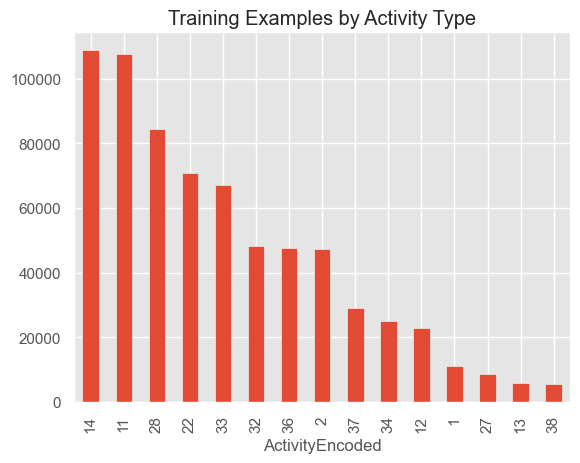

In [155]:
# Group the data by the column "Exercise Code" and count the occurrences
exercise_code_counts = df['ActivityEncoded'].value_counts()

# Convert to a dictionary for better readability
exercise_code_dict = exercise_code_counts.to_dict()

# Display the unique strings and their counts
for code, count in exercise_code_dict.items():
    print(f"ActivityEncoded: {code}, Instances: {count}")

# by activity type
df['ActivityEncoded'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

In [156]:
LABELS = [
    "30DBP","SACLR","APULL","MTE","45DBP","SAOCTE","IDBC","CGCR","DWC","SAODTE","DSP","SBLP","MIBP","DLR","CGOCTE"
]

LABEL = 'ActivityEncoded'
le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

# Group the data by the column "Exercise Code" and count the occurrences
exercise_code_counts = df['activity'].value_counts()

# Convert to a dictionary for better readability
exercise_code_dict = exercise_code_counts.to_dict()

# Display the unique strings and their counts
for code, count in exercise_code_dict.items():
    print(f"ActivityEncoded: {code}, Instances: {count}")

df.info()
df.head(10)

ActivityEncoded: SACLR, Instances: 108801
ActivityEncoded: 30DBP, Instances: 107622
ActivityEncoded: APULL, Instances: 84517
ActivityEncoded: MTE, Instances: 70663
ActivityEncoded: 45DBP, Instances: 67107
ActivityEncoded: SAOCTE, Instances: 48152
ActivityEncoded: IDBC, Instances: 47718
ActivityEncoded: CGCR, Instances: 47434
ActivityEncoded: DWC, Instances: 29214
ActivityEncoded: SAODTE, Instances: 25102
ActivityEncoded: DSP, Instances: 22940
ActivityEncoded: SBLP, Instances: 11007
ActivityEncoded: MIBP, Instances: 8570
ActivityEncoded: DLR, Instances: 5887
ActivityEncoded: CGOCTE, Instances: 5724
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690458 entries, 0 to 690457
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   seconds_elapsed            690458 non-null  float64
 1   wristMotion_rotationRateX  690458 non-null  float64
 2   wristMotion_rotationRateY  690458 non-null  float64

,seconds_elapsed,wristMotion_rotationRateX,wristMotion_rotationRateY,wristMotion_rotationRateZ,wristMotion_gravityX,wristMotion_gravityY,wristMotion_gravityZ,wristMotion_accelerationX,wristMotion_accelerationY,wristMotion_accelerationZ,wristMotion_quaternionW,wristMotion_quaternionX,wristMotion_quaternionY,wristMotion_quaternionZ,Weight,Set,Reps,activity,ActivityEncoded,FileNumber
0,2.0,2.2,-0.9,-0.8,-0.2,0.8,-0.6,0.3,-0.0,0.2,0.5,-0.1,-0.4,0.7,61.0,1.0,12.0,APULL,2,1
1,2.0,2.1,-0.9,-0.7,-0.2,0.8,-0.6,0.3,-0.0,0.2,0.5,-0.1,-0.4,0.7,61.0,1.0,12.0,APULL,2,1
2,2.0,2.1,-0.9,-0.6,-0.2,0.8,-0.6,0.3,-0.0,0.2,0.5,-0.1,-0.4,0.7,61.0,1.0,12.0,APULL,2,1
3,2.0,2.1,-0.8,-0.5,-0.2,0.7,-0.6,0.3,-0.1,0.2,0.5,-0.1,-0.4,0.7,61.0,1.0,12.0,APULL,2,1
4,2.0,2.0,-0.8,-0.5,-0.2,0.7,-0.7,0.3,-0.1,0.2,0.5,-0.1,-0.4,0.7,61.0,1.0,12.0,APULL,2,1
5,2.1,2.0,-0.8,-0.4,-0.2,0.7,-0.7,0.3,-0.1,0.2,0.5,-0.1,-0.4,0.8,61.0,1.0,12.0,APULL,2,1
6,2.1,2.0,-0.8,-0.3,-0.2,0.7,-0.7,0.3,-0.1,0.2,0.5,-0.1,-0.4,0.8,61.0,1.0,12.0,APULL,2,1
7,2.1,2.0,-0.7,-0.3,-0.2,0.7,-0.7,0.3,-0.1,0.2,0.5,-0.1,-0.4,0.8,61.0,1.0,12.0,APULL,2,1
8,2.1,1.9,-0.7,-0.2,-0.2,0.7,-0.7,0.3,-0.1,0.1,0.5,-0.1,-0.4,0.8,61.0,1.0,12.0,APULL,2,1
9,2.1,1.9,-0.7,-0.1,-0.2,0.7,-0.7,0.3,-0.1,0.1,0.5,-0.1,-0.4,0.8,61.0,1.0,12.0,APULL,2,1


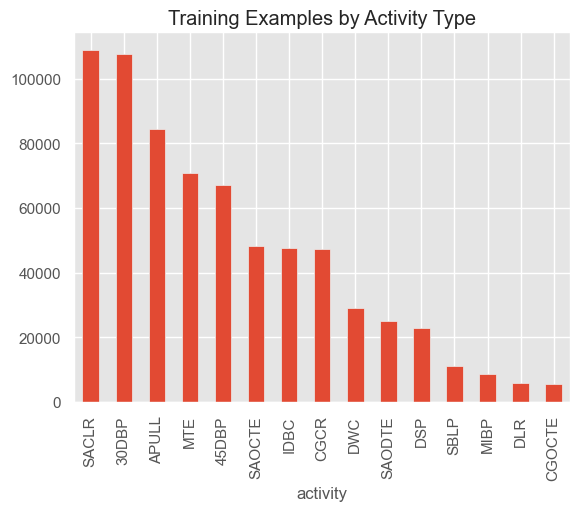

In [157]:
# by activity type
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

In [158]:
unique_count = df['FileNumber'].nunique()

df_train = df[df['FileNumber'] <= int(unique_count*0.7)]
df_test = df[df['FileNumber'] > int(unique_count*0.7)]

In [159]:
pd.options.mode.chained_assignment = None  # default='warn'

df_train['wristMotion_accelerationX'] = df_train['wristMotion_accelerationX'] / df_train['wristMotion_accelerationX'].max()
df_train['wristMotion_accelerationY'] = df_train['wristMotion_accelerationY'] / df_train['wristMotion_accelerationY'].max()
df_train['wristMotion_accelerationZ'] = df_train['wristMotion_accelerationZ'] / df_train['wristMotion_accelerationZ'].max()

df_train['wristMotion_rotationRateX'] = df_train['wristMotion_rotationRateX'] / df_train['wristMotion_rotationRateX'].max()
df_train['wristMotion_rotationRateY'] = df_train['wristMotion_rotationRateY'] / df_train['wristMotion_rotationRateY'].max()
df_train['wristMotion_rotationRateZ'] = df_train['wristMotion_rotationRateZ'] / df_train['wristMotion_rotationRateZ'].max()

# Round the normalized values to 4 decimal places
df_train = df_train.round({'wristMotion_accelerationX':4, 'wristMotion_accelerationY':4, 'wristMotion_accelerationZ': 4,'wristMotion_rotationRateX':4, 'wristMotion_rotationRateY':4, 'wristMotion_rotationRateZ': 4})

# Display the first few rows
df_train.head()

,seconds_elapsed,wristMotion_rotationRateX,wristMotion_rotationRateY,wristMotion_rotationRateZ,wristMotion_gravityX,wristMotion_gravityY,wristMotion_gravityZ,wristMotion_accelerationX,wristMotion_accelerationY,wristMotion_accelerationZ,wristMotion_quaternionW,wristMotion_quaternionX,wristMotion_quaternionY,wristMotion_quaternionZ,Weight,Set,Reps,activity,ActivityEncoded,FileNumber
0,2.0,0.5,-0.2,-0.2,-0.2,0.8,-0.6,0.4,-0.1,0.3,0.5,-0.1,-0.4,0.7,61.0,1.0,12.0,APULL,2,1
1,2.0,0.5,-0.2,-0.2,-0.2,0.8,-0.6,0.4,-0.1,0.3,0.5,-0.1,-0.4,0.7,61.0,1.0,12.0,APULL,2,1
2,2.0,0.5,-0.2,-0.1,-0.2,0.8,-0.6,0.4,-0.1,0.3,0.5,-0.1,-0.4,0.7,61.0,1.0,12.0,APULL,2,1
3,2.0,0.5,-0.2,-0.1,-0.2,0.7,-0.6,0.4,-0.1,0.3,0.5,-0.1,-0.4,0.7,61.0,1.0,12.0,APULL,2,1
4,2.0,0.5,-0.2,-0.1,-0.2,0.7,-0.7,0.4,-0.1,0.3,0.5,-0.1,-0.4,0.7,61.0,1.0,12.0,APULL,2,1


In [160]:
from scipy.stats import mode
import numpy as np

def create_segments_and_labels(df, time_steps, step, label_name):
    # 6 features: 3 accelerometer + 3 gyroscope
    N_FEATURES = 6

    # Initialize lists for segments and labels
    segments = []
    labels = []

    # Create overlapping or non-overlapping segments
    for i in range(0, len(df) - time_steps, step):
        # Collect wrist motion accelerometer data
        acc_x = df['wristMotion_accelerationX'].values[i: i + time_steps]
        acc_y = df['wristMotion_accelerationY'].values[i: i + time_steps]
        acc_z = df['wristMotion_accelerationZ'].values[i: i + time_steps]

        # Collect wrist motion gyroscope data
        gyro_x = df['wristMotion_rotationRateX'].values[i: i + time_steps]
        gyro_y = df['wristMotion_rotationRateY'].values[i: i + time_steps]
        gyro_z = df['wristMotion_rotationRateZ'].values[i: i + time_steps]


        # Find the most frequent label in the segment
        segment_labels = df[label_name][i: i + time_steps]
        label = mode(segment_labels, axis=None).mode # Extract the mode correctly

        # Append the segment (transpose to get shape (time_steps, N_FEATURES))
        segments.append([acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z])
        labels.append(label)
        
    # Convert segments and labels into NumPy arrays
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y

In [161]:
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'

In [162]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (1637, 400, 6)
1637 training samples
y_train shape:  (1637,)


In [163]:
# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size
print(list(le.classes_))
print(n_time_periods, n_sensors)

['30DBP', '45DBP', 'APULL', 'CGCR', 'CGOCTE', 'DLR', 'DSP', 'DWC', 'IDBC', 'MIBP', 'MTE', 'SACLR', 'SAOCTE', 'SAODTE', 'SBLP']
400 6


In [164]:
input_shape = (n_time_periods * n_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input shape:', input_shape)

x_train shape: (1637, 2400)
input shape: 2400


In [165]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [166]:
from tensorflow.keras.utils import to_categorical

y_train_categorical = to_categorical(y_train, n_classes)
y_train_hot = to_categorical(y_train, n_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (1637, 15)


In [167]:
model_m = Sequential()

model_m.add(Reshape((TIME_PERIODS, 6), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(n_classes, activation='softmax'))

model_m.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_5 (Reshape)                  │ (None, 400, 6)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 400, 100)            │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 400, 100)            │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 400, 100)            │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 400, 100)            │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 400, 100)            │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 400, 100)            │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 15)                  │         600,015 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 651,215 (2.48 MB)

 Trainable params: 651,215 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [168]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.keras',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

In [169]:
BATCH_SIZE = 1000
EPOCHS = 50

history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.0446 - loss: 2.7021 - val_accuracy: 0.0061 - val_loss: 2.6643
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 861ms/step - accuracy: 0.1881 - loss: 2.5315 - val_accuracy: 0.0000e+00 - val_loss: 2.8318
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 915ms/step - accuracy: 0.1836 - loss: 2.2785 - val_accuracy: 0.1098 - val_loss: 3.2842


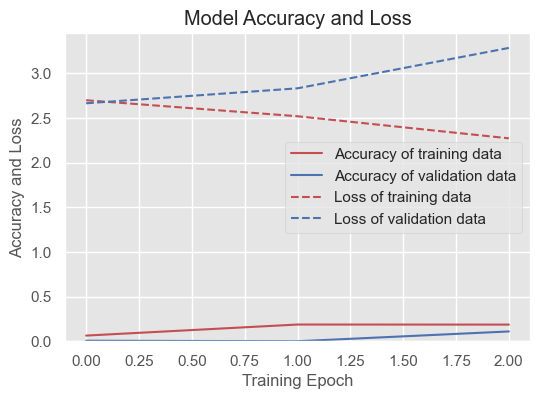

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       226
         1.0       0.20      0.97      0.34       244
         2.0       0.50      0.74      0.59       323
         3.0       0.00      0.00      0.00       155
         6.0       0.00      0.00      0.00        81
         7.0       0.00      0.00      0.00        91
         8.0       0.00      0.00      0.00       167
         9.0       0.00      0.00      0.00        23
        10.0       0.00      0.00      0.00        43
        11.0       0.00      0.00      0.00       163
        12.0       0.00      0.00      0.00        81
        13.0       0.00      0.00      0.00        40

    accuracy                           0.29      1637
   macro avg       0.06      0.14      0.08      1637
weighted avg       0.13      0.29      0.17      1637



In [170]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


# Predict => confusion matrix for train data
y_pred_train = model_m.predict(x_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)  # class with the highest probabilty
print(classification_report(y_train, max_y_pred_train))  # confusion matrix: classification_report from sklearn

In [119]:
# normalize test data

df_test['wristMotion_accelerationX'] = df_train['wristMotion_accelerationX'] / df_train['wristMotion_accelerationX'].max()
df_test['wristMotion_accelerationY'] = df_train['wristMotion_accelerationY'] / df_train['wristMotion_accelerationY'].max()
df_test['wristMotion_accelerationZ'] = df_train['wristMotion_accelerationZ'] / df_train['wristMotion_accelerationZ'].max()

df_test['wristMotion_rotationRateX'] = df_train['wristMotion_rotationRateX'] / df_train['wristMotion_rotationRateX'].max()
df_test['wristMotion_rotationRateY'] = df_train['wristMotion_rotationRateY'] / df_train['wristMotion_rotationRateY'].max()
df_test['wristMotion_rotationRateZ'] = df_train['wristMotion_rotationRateZ'] / df_train['wristMotion_rotationRateZ'].max()

df_test = df_train.round({'wristMotion_accelerationX':4, 'wristMotion_accelerationY':4, 'wristMotion_accelerationZ': 4,'wristMotion_rotationRateX':4, 'wristMotion_rotationRateY':4, 'wristMotion_rotationRateZ': 4})


x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test_categorical = to_categorical(y_test, n_classes)
y_test = to_categorical(y_test, n_classes)

score_dnn = model_m.evaluate(x_test, y_test, verbose=1)

print()
print('Accuracy on test data: %0.3f' % score_dnn[1])
print('Loss on test data: %0.3f' % score_dnn[0])

103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7488 - loss: 0.8143

Accuracy on test data: 0.666
Loss on test data: 1.277


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


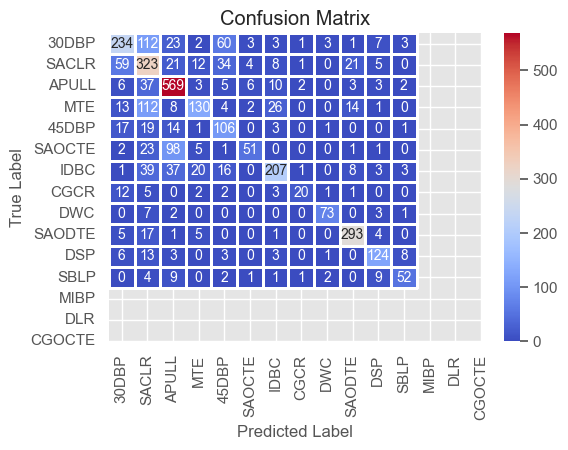

              precision    recall  f1-score   support

           0       0.66      0.52      0.58       452
           1       0.45      0.66      0.54       488
           2       0.72      0.88      0.80       646
           3       0.72      0.42      0.53       310
           6       0.45      0.65      0.54       162
           7       0.76      0.28      0.41       182
           8       0.78      0.62      0.69       335
           9       0.77      0.43      0.56        46
          10       0.90      0.85      0.87        86
          11       0.86      0.90      0.88       326
          12       0.78      0.77      0.77       161
          13       0.74      0.64      0.69        81

    accuracy                           0.67      3275
   macro avg       0.72      0.64      0.65      3275
weighted avg       0.69      0.67      0.66      3275



In [120]:
def show_confusion_matrix(validaitons, predictions, title=None):
    matrix = metrics.confusion_matrix(validaitons, predictions)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title) 
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))